In [10]:
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# 윈도우 : "Malgun Gothic"
# 맥 : "AppleGothic"
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()
    # colab 사용자는 system_name이 'Linux'로 확인

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont

        font_family = "NanumBarunGothic"
    return font_family



# 폰트설정
plt.rc("font", family=get_font_family())
# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
from IPython.display import set_matplotlib_formats

%config InlineBackend.figure_format = 'retina'

In [9]:
PATH = '/Users/sabin/Documents/Project/AIDA/Trend-analysis/Keyphrase/임대차3법/KeyBERT/keywords.json'
KEYWORD = 5
with open(PATH, 'r',encoding='UTF8') as file:
    keywords = json.load(file)

keyword = []
day = []
for keyword_dict in keywords:
    keyword.append('/'.join(list(keyword_dict.values())[0]))
    day.append(list(keyword_dict.keys())[0])

In [10]:
df = pd.DataFrame({'day':day,'keyword':keyword}).sort_values(by='day').drop_duplicates().reset_index(drop=True) # 중복된 기사에서 나온 키워드 제거

In [11]:
# keyword 분리 해내기
# keyword 1, 2, 3, 4, 5에 따라 가중치 ?
for i in range(KEYWORD):
    df[f'keyword{i+1}'] = df['keyword'].map(lambda x:x.split('/')[i])
df.head()

,day,keyword,keyword1,keyword2,keyword3,keyword4,keyword5
0,2020/07/01,전세 매물/임대차 전월세/임대료 인상/상승 월세/전월세 고제,전세 매물,임대차 전월세,임대료 인상,상승 월세,전월세 고제
1,2020/07/01,전월세 고제/전월세 시장/규제 임대료/혜택 임대차/상한 임대,전월세 고제,전월세 시장,규제 임대료,혜택 임대차,상한 임대
2,2020/07/01,최근 전세/금리 전세/전세 수요/월세 거래량/전세 매물,최근 전세,금리 전세,전세 수요,월세 거래량,전세 매물
3,2020/07/02,가격 주택/전망 전세/수도권 상승/부동산 대책/전세 상반기,가격 주택,전망 전세,수도권 상승,부동산 대책,전세 상반기
4,2020/07/02,감소 하반기/수요 영향/하반기 셋값/전세 상승/주택 경기,감소 하반기,수요 영향,하반기 셋값,전세 상승,주택 경기


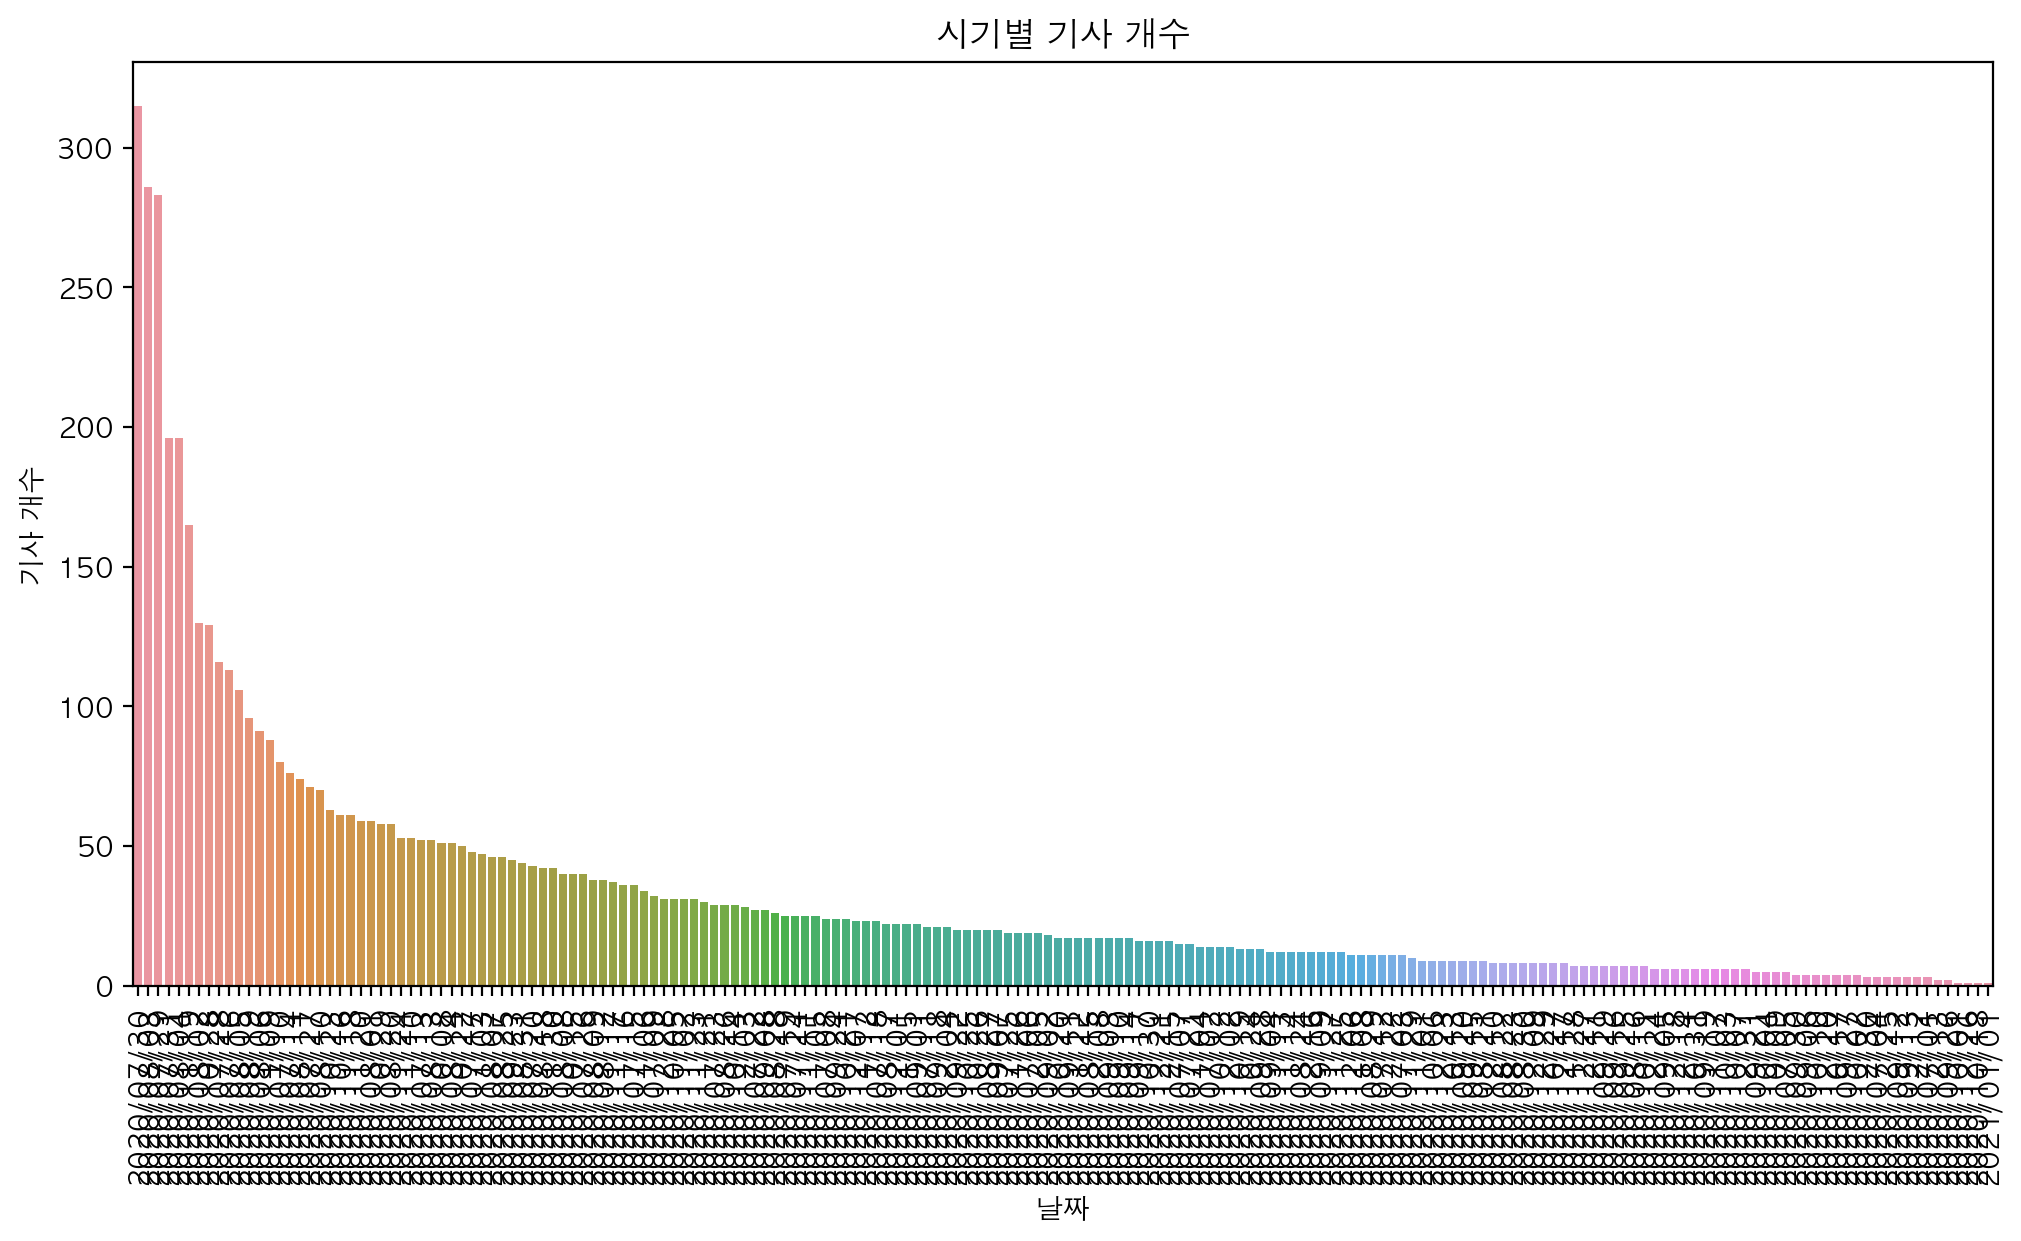

In [12]:
# 시간이 지날 수록 언급량 감소
plt.figure(figsize=(12,6))
plt.title('시기별 기사 개수')

sns.countplot(data=df, x='day', order=df['day'].value_counts().index)
plt.xticks(rotation=90)
plt.ylabel('기사 개수')
plt.xlabel('날짜')
plt.show()

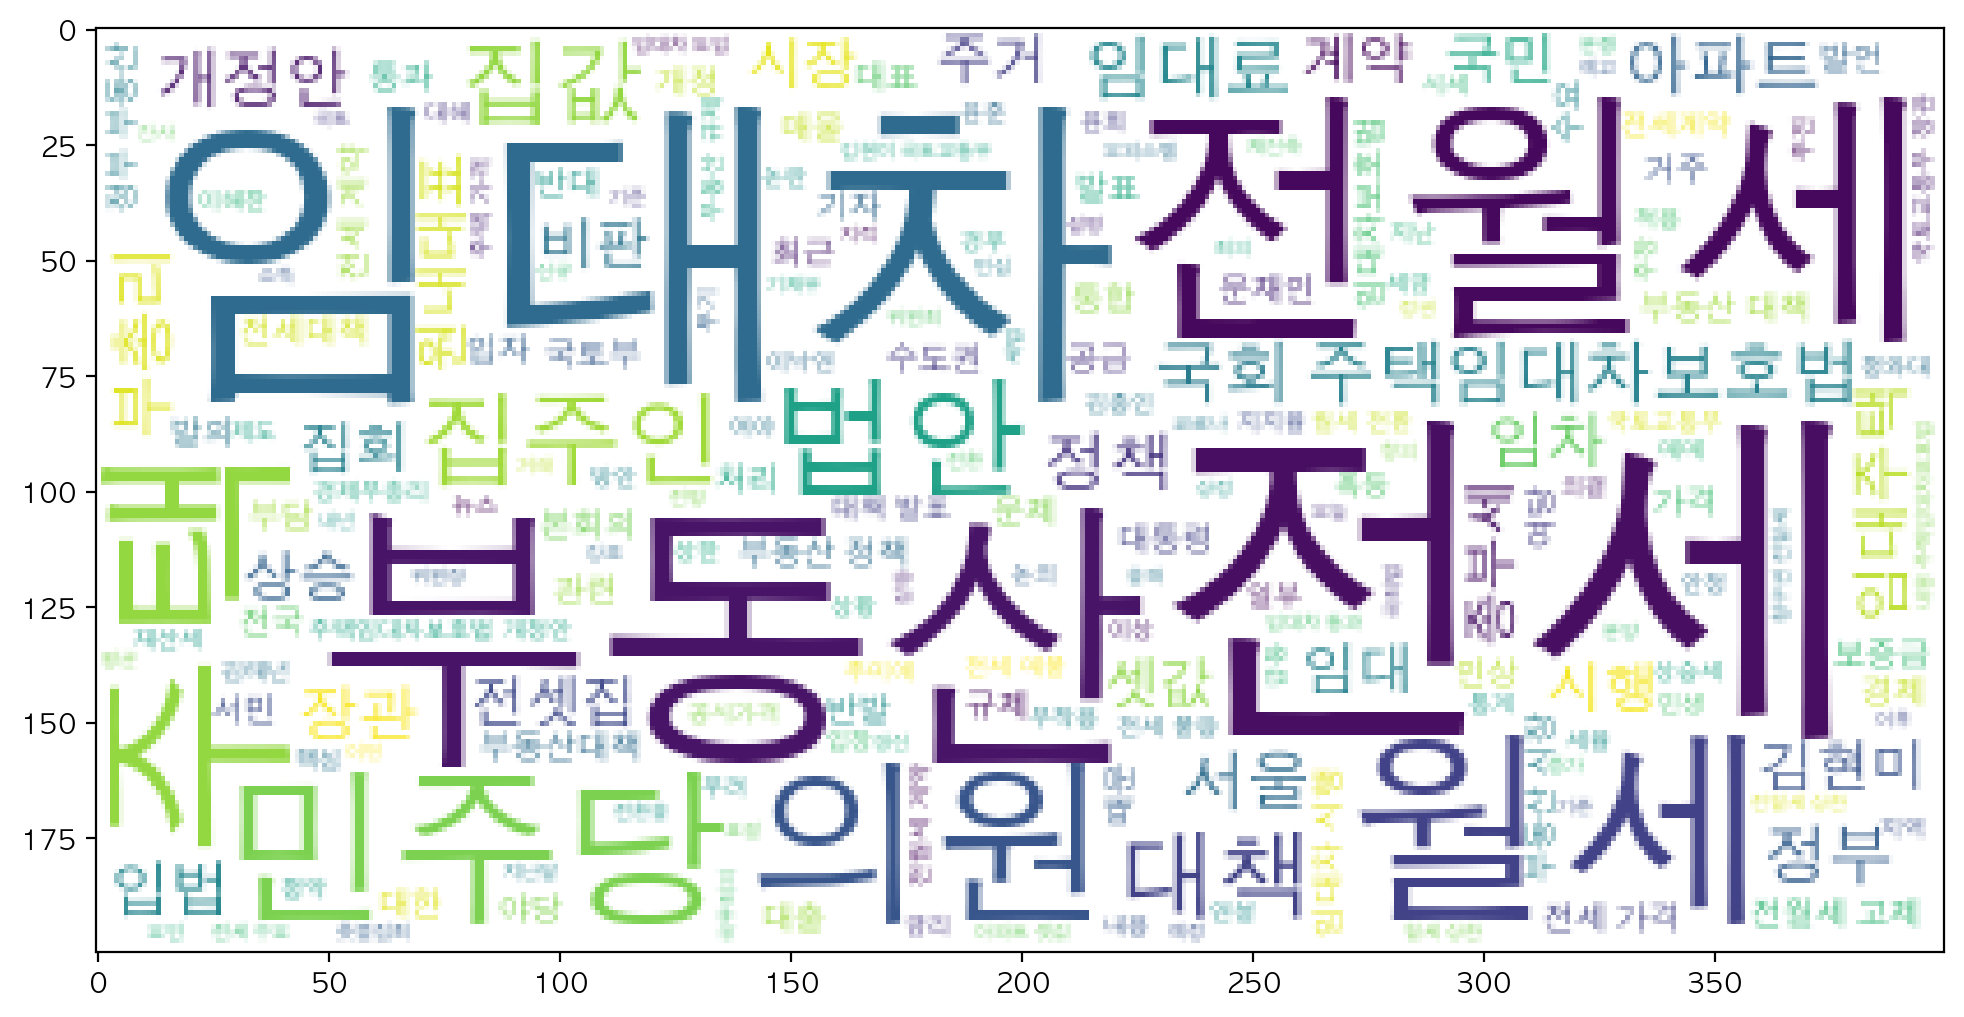

In [13]:
# wordcloud for keyword
from wordcloud import WordCloud

font_path = '/Library/Fonts/AppleGothic.ttf'
# 키워드 1
wordcloud = WordCloud(
    font_path=font_path,
    background_color='white',                             # 배경 색깔 정하기
)
wordcloud = wordcloud.generate(' '.join(df['keyword1']))
plt.figure(figsize=(12,6))
plt.imshow(wordcloud)
plt.savefig('임대차3법wordcloud.png')

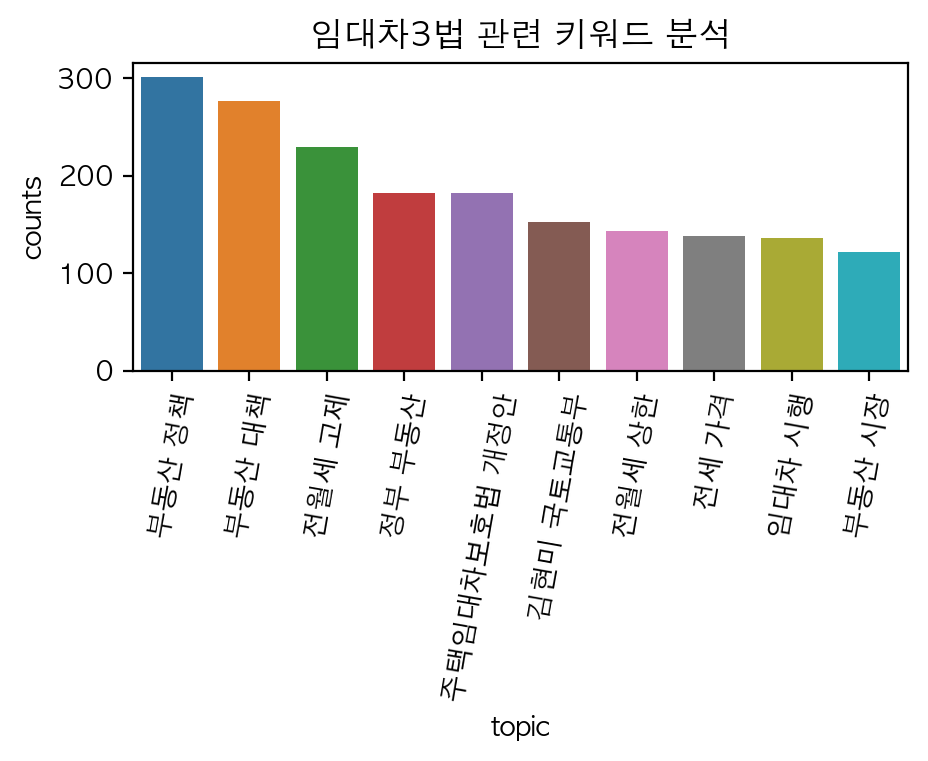

In [14]:
value_counts = []
for i in range(KEYWORD):
    value_counts.append(df[f'keyword{i+1}'].value_counts())

df_counts = pd.concat(value_counts,axis=1).fillna(0).sum(axis=1).sort_values(ascending=False).reset_index()
df_counts.columns = ['topic','counts']

plt.figure(figsize=(5,2))
plt.title('임대차3법 관련 키워드 분석')
plt.xticks(rotation=80)
_ = sns.barplot(data=df_counts.head(10),x='topic',y='counts',)
plt.savefig('임대차3법_키워드_분석.png')

In [7]:
sub_topic_top5 = list(df_counts.head(5).topic)
sub_topic_top5_counts_by_date = {subtopic:{} for subtopic in sub_topic_top5}
for sub_topic in sub_topic_top5:
    for date in sorted(list(set(day))):
        sub_topic_top5_counts_by_date[sub_topic][date] = (df.loc[df['day']==date,'keyword'].str.contains(sub_topic)).sum()




# 2020/7/31 주택 임대차 보호범 개정안 시행

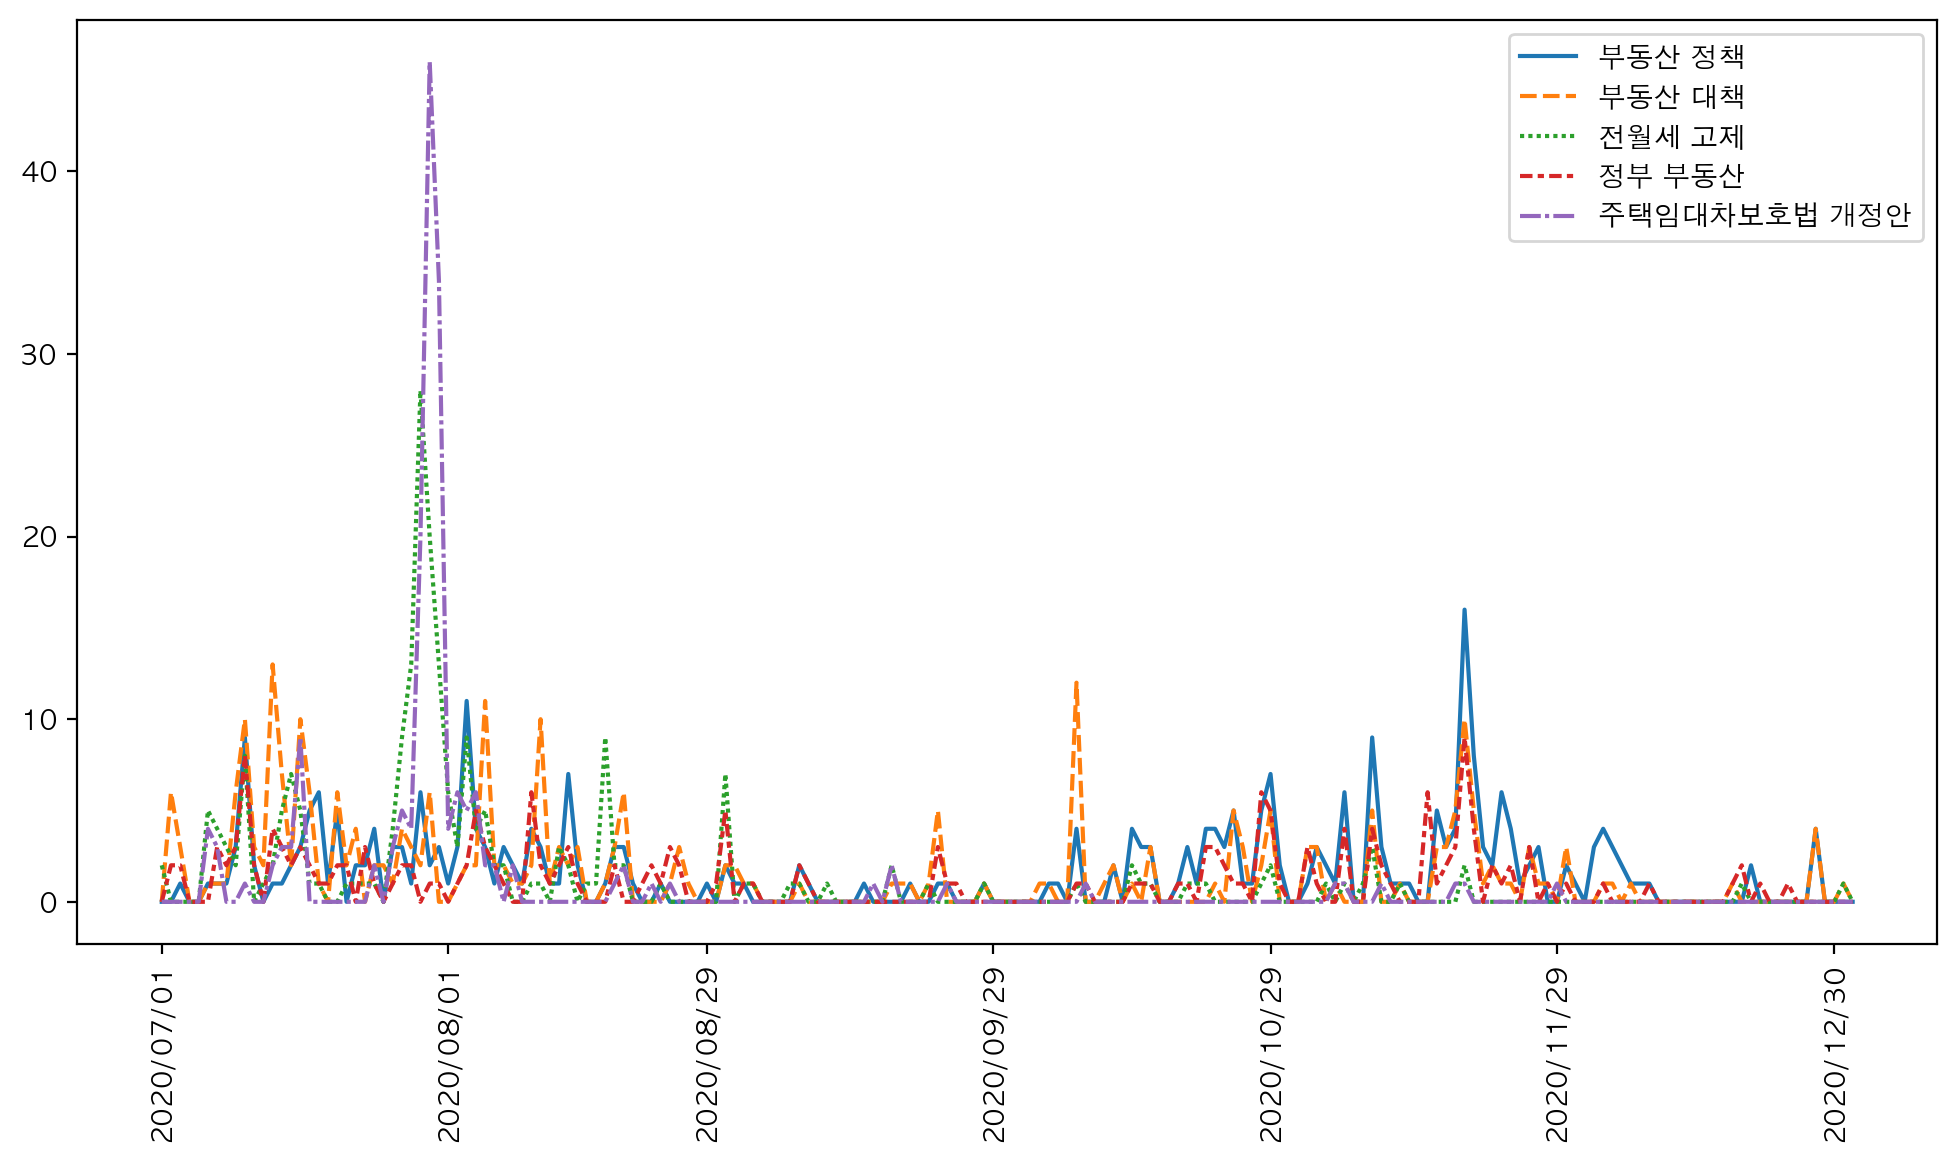

In [75]:
from matplotlib import dates

plt.figure(figsize=(12,6))
plt.xticks(rotation=90)

ax = plt.gca()
ax.xaxis.set_major_locator(dates.MonthLocator())

_ = sns.lineplot(sub_topic_top5_counts_by_date)
plt.savefig('임대차보호법_개정안_시행_일자.png')

# NSI 긍부정 지수

In [12]:
df_nsi = pd.read_csv('/Users/sabin/Documents/Project/AIDA/Trend-analysis/NSI/NSI_dataset/임대차3법nsi.csv')
df_nsi['Negative_percent'] = df_nsi['Negative'] / (df_nsi['Negative']+df_nsi['Positive'])
df_nsi['Positive_percent'] = df_nsi['Positive'] / (df_nsi['Negative']+df_nsi['Positive'])
df_nsi

,날짜,Negative,Positive,X_t,nsi,Negative_percent,Positive_percent
0,2020/07/01,39.0,25.0,-0.218750,NaN,0.609375,0.390625
1,2020/07/02,181.0,113.0,-0.231293,92.929,0.615646,0.384354
2,2020/07/03,287.0,151.0,-0.310502,88.545,0.655251,0.344749
3,2020/07/04,317.0,158.0,-0.334737,89.395,0.667368,0.332632
4,2020/07/05,353.0,189.0,-0.302583,95.522,0.651292,0.348708
...,...,...,...,...,...,...,...
710,2022/06/26,723.0,880.0,0.097941,128.194,0.451029,0.548971
711,2022/06/27,675.0,826.0,0.100600,128.228,0.449700,0.550300
712,2022/06/28,531.0,324.0,-0.242105,100.817,0.621053,0.378947
713,2022/06/29,467.0,240.0,-0.321075,94.501,0.660537,0.339463


In [14]:
df_nsi.to_csv('/Users/sabin/Documents/Project/AIDA/Trend-analysis/NSI/임대차3법nsi_df.csv',index=False)

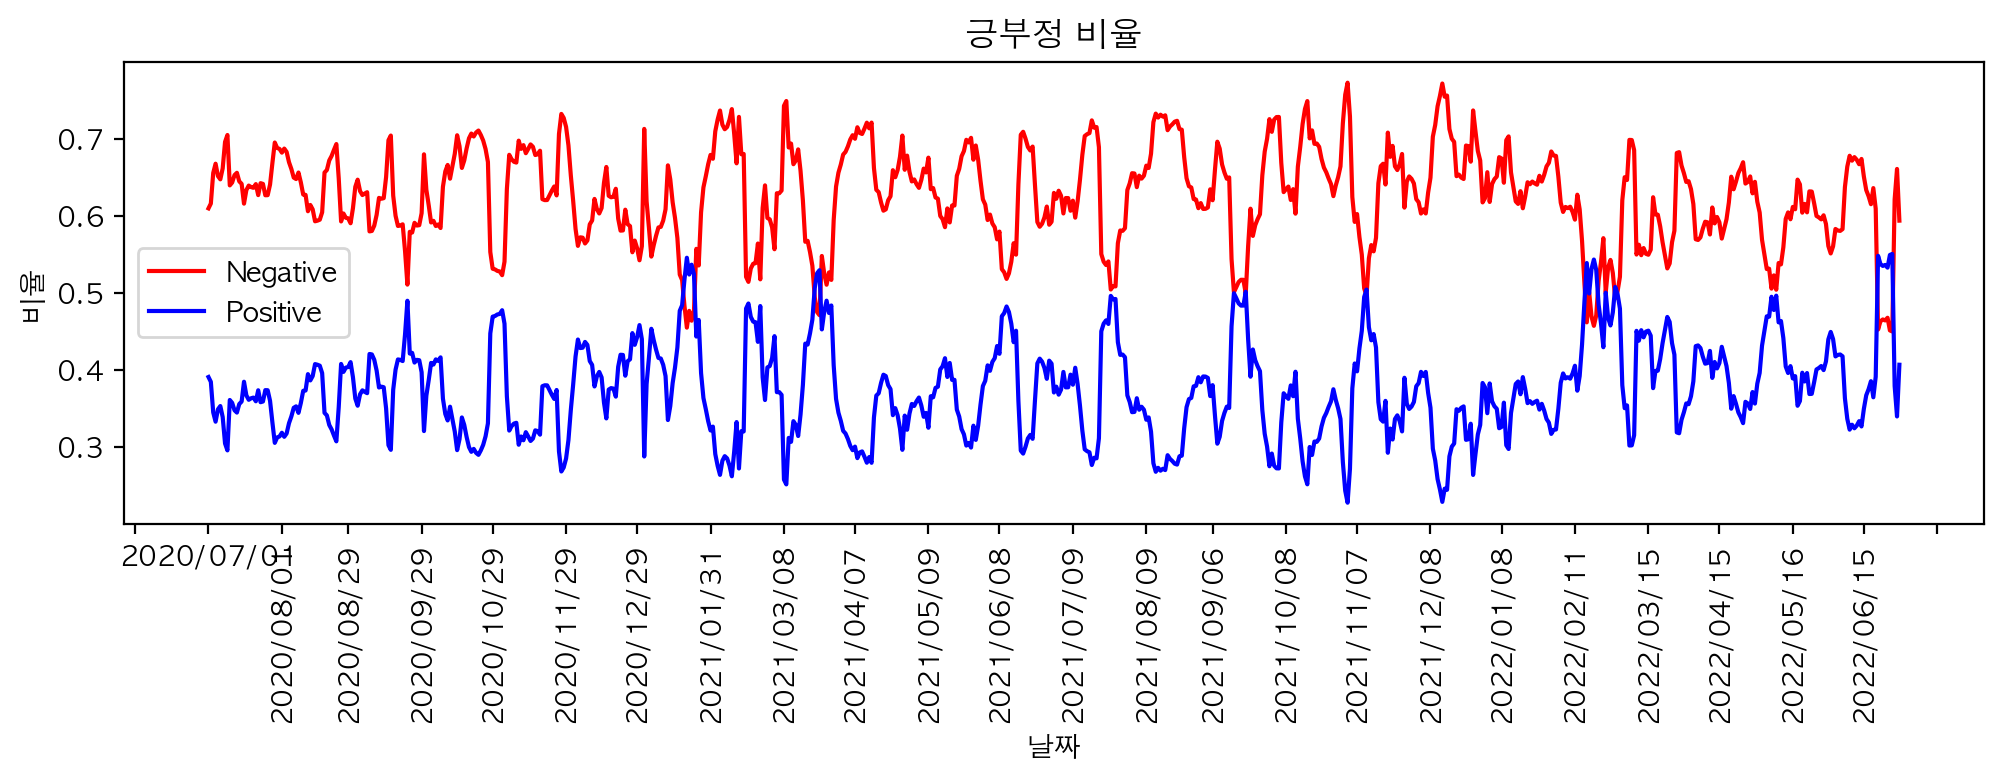

In [78]:
plt.figure(figsize=(12,3))
plt.title('긍부정 비율')
ax = plt.gca()

ax.xaxis.set_major_locator(dates.MonthLocator())
plt.xticks(rotation=90)
plt.ylabel('비율')

sns.lineplot(data=df_nsi,x='날짜',y='Negative_percent',color='r', label='Negative', ax=ax)
sns.lineplot(data=df_nsi,x='날짜',y='Positive_percent',color='b', label='Positive', ax=ax)

plt.savefig('임대차보호법_개정안_긍부정_비율.png')
# why negative?
# 임대차보호법 개정안이 시행되면서 임대차보호법에 따라 임대차 계약이 불가능해지는 경우가 생김

In [191]:
# 커뮤니티 긍부정 분석 추가

0      0.609375
1      0.615646
2      0.655251
3      0.667368
4      0.651292
         ...   
710    0.451029
711    0.449700
712    0.621053
713    0.660537
714    0.593477
Length: 715, dtype: float64

In [5]:
#keyword multi classification 추가
PATH = '/Users/sabin/Documents/Project/AIDA/Trend-analysis/Keyphrase_classification/rent_multi_content.json'

with open(PATH, 'r', encoding='UTF8') as file:
    multi = pd.Series(np.array(json.load(file))[:,1])

In [6]:
multi.value_counts().values

array([28407, 11182,  9842,   569])

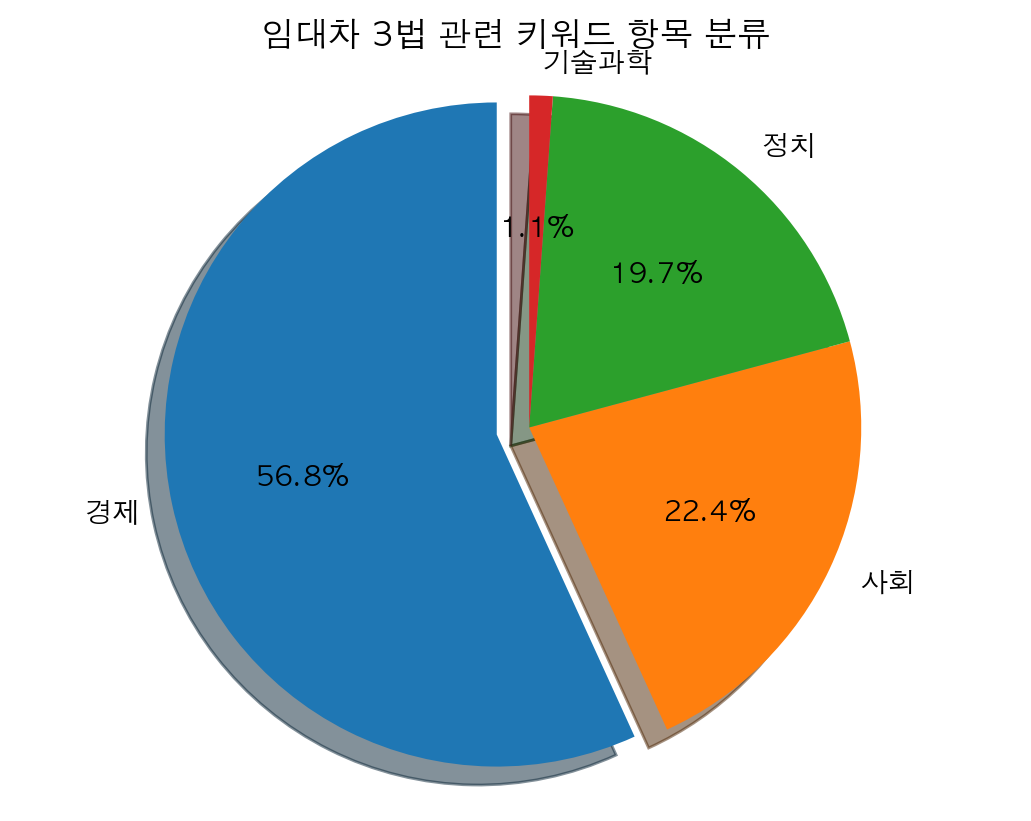

<Figure size 640x480 with 0 Axes>

In [7]:
labels = multi.value_counts().index
sizes = multi.value_counts().values
explode = (0.1, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')

plt.title('임대차 3법 관련 키워드 항목 분류')
plt.show()
plt.savefig('임대차3법_키워드_항목_분류.png')